**Explanation**

## Bipartite Ranking Algorithm
This notebook implements a bipartite ranking algorithm that ranks items based on user ratings while iteratively refining user reputations. The goal is to achieve a fair ranking system where user biases are minimized.

### **How it Works**
1. **Initialize User Reputation**: All users start with equal reputation.
2. **Compute Item Rankings**: Item scores are calculated using weighted user ratings.
3. **Update User Reputation**: Users with large rating errors are penalized.
4. **Iterate Until Convergence**: The process is repeated until rankings stabilize.

This notebook will:
- Load the dataset.
- Apply the bipartite ranking algorithm.
- Visualize the resulting item rankings.




**1.    Imports**

In [17]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

**2.    Load Dataset**

In [6]:
file_path = "/home/martim/Desktop/tese/datasets/amazon_beauty/Luxury_Beauty_5_normalized.json"  # Replace with your dataset path

# Load dataset
with open(file_path, 'r') as f:
    data = [json.loads(line) for line in f]
df = pd.DataFrame(data)

# Get unique users and items
users = df["reviewerID"].unique()
items = df["asin"].unique()

df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,normalizedOverall,vote,image
0,5.0,True,"01 5, 2018",A2HOI48JK8838M,B00004U9V2,{'Size:': ' 0.9 oz.'},DB,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,1515110400,1.0,NaN,NaN
1,5.0,True,"04 5, 2017",A1YIPEY7HX73S7,B00004U9V2,{'Size:': ' 3.5 oz.'},Ajaey,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,1491350400,1.0,NaN,NaN
2,5.0,True,"03 27, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 250 g'},D. Jones,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,1490572800,1.0,NaN,NaN
3,5.0,True,"03 20, 2017",A2R4UNHFJBA6PY,B00004U9V2,{'Size:': ' 3.5 oz.'},Amazon Customer,Thanks!!,Five Stars,1489968000,1.0,NaN,NaN
4,5.0,True,"02 28, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 0.9 oz.'},D. Jones,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,1488240000,1.0,NaN,NaN


**3.    Bipartite Ranking Algorithm**

In [11]:

def bipartite_ranking_algorithm(lambda_factor=0.3, tol=1e-6, max_iter=2):

    # Get unique users and items
    users = df["reviewerID"].unique()
    items = df["asin"].unique()

    # Initialize user reputations (equal for all users)
    user_reputation = {user: 1.0 for user in users}

    for iteration in range(max_iter):
        prev_item_rankings = {} if iteration == 0 else item_rankings.copy()

        # Update item rankings
        item_rankings = {}
        for item in items:
            item_ratings = df[df["asin"] == item]
            users_who_rated = item_ratings["reviewerID"].values

            if len(users_who_rated) == 0:
                continue

            weighted_sum = sum(user_reputation[u] * r for u, r in zip(users_who_rated, item_ratings["normalizedOverall"].values))
            total_weight = len(users_who_rated)

            item_rankings[item] = weighted_sum / total_weight if total_weight > 0 else 0

        # Update user reputations
        for user in users:
            user_ratings = df[df["reviewerID"] == user]
            items_rated = user_ratings["asin"].values

            if len(items_rated) == 0:
                continue

            rating_errors = [abs(r - item_rankings[i]) for i, r in zip(items_rated, user_ratings["normalizedOverall"].values)]
            avg_error = sum(rating_errors) / len(rating_errors)

            user_reputation[user] = 1 - lambda_factor * avg_error
            user_reputation[user] = max(user_reputation[user], 0)  # Ensure non-negative reputation

        # Check for convergence
        if iteration > 0:
            ranking_diff = sum(abs(prev_item_rankings[i] - item_rankings[i]) for i in items if i in prev_item_rankings)
            if ranking_diff < tol:
                break

    return item_rankings


**4. Compute Item Rankings**


In [12]:
# Compute rankings using the bipartite ranking algorithm
rankings = bipartite_ranking_algorithm()

# Display top-ranked items
sorted_rankings = sorted(rankings.items(), key=lambda x: x[1], reverse=True)
sorted_rankings[:10]


[('B000VXUTEI', 1.0),
 ('B000VZOJ6U', 0.9969230769230769),
 ('B0013EGTMA', 0.996),
 ('B000YTA570', 0.99168),
 ('B0015Z531A', 0.9913214285714286),
 ('B000VIZEOS', 0.9895968041620216),
 ('B00J4OTK9A', 0.9873914242620125),
 ('B0013EF2DC', 0.986),
 ('B00175S7R0', 0.9857411764705882),
 ('B0014F812E', 0.9853052298239394)]

**5. Visualizing the Distribution of Item Rankings**

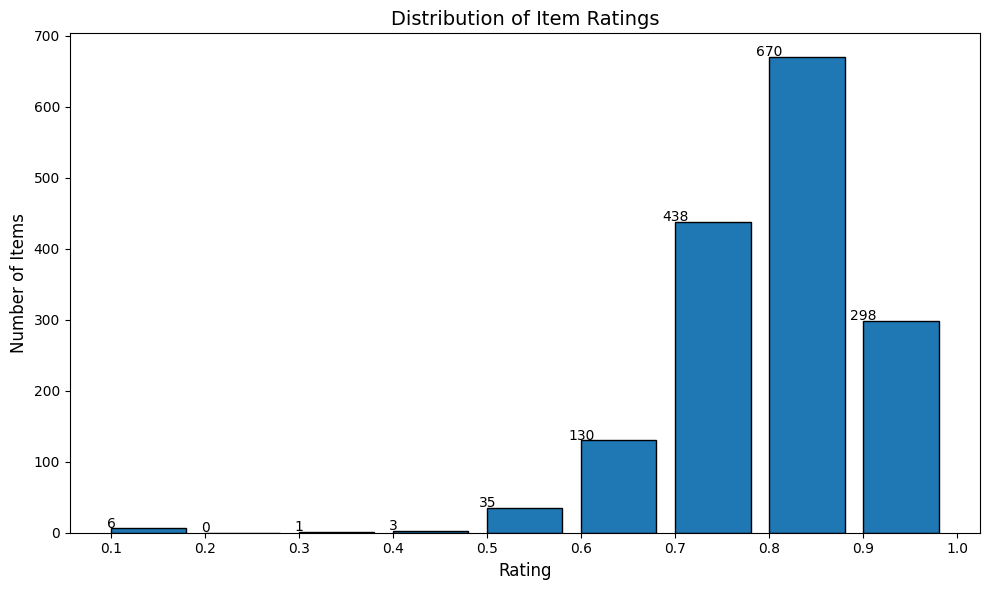

In [13]:
# Extract the ratings from the rankings
ratings = list(rankings.values())

# Define bins for the ratings (from 0.1 to 1.0 with steps of 0.1)
bins = np.arange(0.1, 1.1, 0.1)

# Count how many items fall into each rating bin
hist, bin_edges = np.histogram(ratings, bins=bins)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist, width=0.08, align='edge', edgecolor='black')

# Adding numbers on top of bars
for i in range(len(hist)):
    plt.text(bin_edges[i], hist[i] + 1, str(hist[i]), ha='center', fontsize=10)

# Finalize the plot
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Items', fontsize=12)
plt.title('Distribution of Item Ratings', fontsize=14)
plt.xticks(bins)  # Ensure the x-ticks correspond to the rating bins
plt.tight_layout()
plt.show()


**6. Metrics**


**6.1   Effectiveness**

In [21]:
def compute_aggregated_average_ranking(df):
    return df.groupby("asin")["normalizedOverall"].mean().to_dict()

def compute_kendall_tau(ranking_1, ranking_2):
    common_items = set(ranking_1.keys()) & set(ranking_2.keys())  # Ensure only common items are compared
    
    if len(common_items) < 2:  # Need at least two rankings to compute Kendall's tau
        return 0
    
    sorted_items = sorted(common_items)  # Sort items to ensure consistent order
    
    list_1 = [ranking_1[item] for item in sorted_items]
    list_2 = [ranking_2[item] for item in sorted_items]
    
    return kendalltau(list_1, list_2).correlation

# Compute the aggregated average ranking
aa_rankings = compute_aggregated_average_ranking(df)

# Compute Kendall’s tau for the entire dataset
tau_value = compute_kendall_tau(rankings, aa_rankings)
print(f"Kendall’s τ: {tau_value:.4f}")



Kendall’s τ: 0.9653


**6.2   Bias**